X-ray spectroscopies
=================

Processes considered
--------------------------------

*General aspects. In X-ray absorption spectroscopy the photon energy is tuned such that core electrons are targeted and excited to either bound or continuum states, and X-ray emission spectroscopy measures the subsequent decay from such an excited state. These core excitations/de-excitations exhibit strong relaxation effects, making theoretical considerations of the processes particularly challenging. While the removal of a valence electron leaves the remaining electrons relatively unaffected, removing core electrons has a substantial effect on the other electrons due to the significant change in the screening of the nucleus. Compare and contrast to UV/vis*

![X-ray processes considered](../img/xray/processes.svg)


- Figure: IP of elements (1s, 2s)?


**Not included (yet)**
- SO-coupling
- beyond electrinc-dipole approximation
- multireference methods

X-ray photoemission spectroscopy
--------------------------------------------------

*We will here focus on calculating ionization potentials (IP:s), from which the isotropic photoemission spectrum is formed by giving each IP the same intensity and then broadening with a function.*

### IP from Koopman's theorem

In [45]:
import veloxchem as vlx
import numpy as np
from mpi4py import MPI
comm = MPI.COMM_WORLD
au2ev = 27.2114
silent_ostream = vlx.OutputStream(None) # suppress program output
mol_str = """
O       0.0000000000     0.0000000000     0.1178336003
H      -0.7595754146    -0.0000000000    -0.4713344012
H       0.7595754146     0.0000000000    -0.4713344012
"""
molecule = vlx.Molecule.read_str(mol_str, units='angstrom')
basis    = vlx.MolecularBasis.read(molecule, "6-31g")
scf_drv  = vlx.ScfRestrictedDriver(comm,silent_ostream)
scf_drv.compute(molecule, basis)
orbital_energies = scf_drv.scf_tensors['E']
print('1s IP from Koopman\'s theorem:',np.around(au2ev*orbital_energies[0],3))

1s IP from Koopman's theorem: -559.501


This is to be compared to the experimental IP of gas phase water, which is 539.9 eV. The overestimation of almost 20 eV is due to lack of **relaxation**, which results from the reorganization of the valence electrons in response to a reduction of screening of the nuclei. An approach for including these effects in IP calculation is to use the $\Delta$SCF approach, in which the difference in total energy between the neutral and a core-hole system is considered as the IP.

### MOM

Describe the approach

Note potential instabilities for post-HF on CH

<div class="alert alert-block alert-info"><b>Note:</b> We currently use pyscf for the illustrations involving core-holes, as VeloxChem lacks MOM (at the moment).</div>

### IP from $\Delta$SCF and $\Delta$MP2


In [46]:
from pyscf import gto, scf
import copy
mol = gto.Mole()
mol.atom  = mol_str; mol.basis = '6-31G'
mol.build(); scfres = scf.UHF(mol); scfres.kernel()
# create a core-hole in beta 1s (MO1)
mo0 = copy.deepcopy(scfres.mo_coeff); occ0 = copy.deepcopy(scfres.mo_occ)
occ0[0][0] = 0.0
scfion = scf.UHF(mol); scfion.conv_tol = 1e-12; scfion.conv_tol_grad = 1e-9
scf.addons.mom_occ(scfion, mo0, occ0)
scfion.kernel()
print('Ionization potential:',np.around(au2ev*(scfion.energy_tot() - scfres.energy_tot()),3),'eV')

converged SCF energy = -75.9838703827192  <S^2> = 6.3353767e-12  2S+1 = 1
converged SCF energy = -56.0754789470866  <S^2> = 0.76257807  2S+1 = 2.0125388
Ionization potential: 541.735 eV


This estimate is now within 2 eV from experiment, and we can include correlation by using the SCF results for MP2 or any other method of your choice:

In [47]:
from pyscf import mp
mp_res = mp.MP2(scfres).run(); mp_ion = mp.MP2(scfion).run()
print('Ionization potential:',np.around(au2ev*(mp_res.e_tot - mp_ion.e_tot),3),'eV')

E(UMP2) = -76.1130483955489  E_corr = -0.129178012829716
E(UMP2) = -56.1523709682674  E_corr = -0.0768920211808384
Ionization potential: -543.158 eV


This currently brings us **away** from experiment, but we note that the basis set is quite limited and ill suited for core properties, and relativistic effects are not included either (more on this below).

### XPS of the ESCA molecule

converged SCF energy = -412.279202540049  <S^2> = 2.7561047e-08  2S+1 = 1.0000001
SCF not converged.
SCF energy = -401.292314355337 after 100 cycles  <S^2> = 0.89495889  2S+1 = 2.140055
converged SCF energy = -401.341585452586  <S^2> = 0.80717734  2S+1 = 2.0563826
SCF not converged.
SCF energy = -401.418569831722 after 100 cycles  <S^2> = 1.1692099  2S+1 = 2.3826119
converged SCF energy = -401.511489489205  <S^2> = 0.79315028  2S+1 = 2.0426946


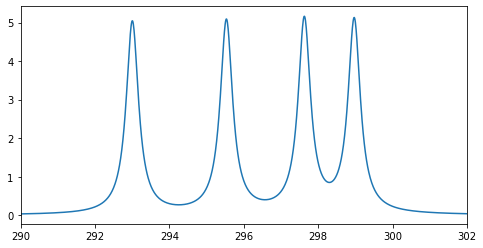

In [33]:
import matplotlib.pyplot as plt
def lorentzian(x, y, xmin, xmax, xstep, gamma):
    xi = np.arange(xmin,xmax,xstep); yi=np.zeros(len(xi))
    for i in range(len(xi)):
        for k in range(len(x)): yi[i] = yi[i] + y[k] * (gamma/2.) / ( (xi[i]-x[k])**2 + (gamma/2.)**2 )
    return xi,yi
uracil   = ' C     0.000000     0.313341     1.284889;\
             C     0.000000    -1.129946     1.193271;\
             C     0.000000    -1.722413    -0.011510;\
             N     0.000000    -1.002386    -1.171240;\
             C     0.000000     0.377102    -1.212137;\
             N     0.000000     0.946281     0.038980;\
             O     0.000000     0.966706     2.309430;\
             O     0.000000     1.007669    -2.246643;\
             H     0.000000    -2.791379    -0.129000;\
             H     0.000000     1.954858     0.054525;\
             H     0.000000    -1.456186    -2.067038;\
             H     0.000000    -1.702677     2.098114'
mol_ura = gto.Mole()
mol_ura.atom  = uracil; mol_ura.basis = '6-31G'
mol_ura.build(); scf_ura = scf.UHF(mol_ura); scf_ura.kernel()
ionization_energies = []
for i in [4,5,6,7]:
    mo0 = copy.deepcopy(scf_ura.mo_coeff); occ0 = copy.deepcopy(scf_ura.mo_occ); occ0[0][i] = 0.0
    ion_tmp = scf.UHF(mol_ura); scf.addons.mom_occ(ion_tmp, mo0, occ0); ion_tmp.max_cycle = 100; ion_tmp.kernel()
    ionization_energies.append(27.2114*(ion_tmp.energy_tot() - scf_ura.energy_tot()))
plt.figure(figsize=(8,4))
xi,yi = lorentzian(ionization_energies,np.ones((len(ionization_energies))),290,302,0.01,0.4)
plt.plot(xi,yi); plt.xlim((290,302)); plt.show()

X-ray absorption spectroscopy
--------------------------------------------

*Focus on NEXAFS, Core-excited states are embedded in a manifold of valence-excited states that needs to be considered by some computationally feasible method.*

![X-ray processes considered](../img/xray/nexafs.svg)

- Global spectrum

### Individual states with CVS-ADC

References to CVS approach and CVS error.

In [34]:
import gator
struct = gator.get_molecule("""
O       0.0000000000     0.0000000000     0.1187290000
H      -0.7532010000    -0.0000000000    -0.4749160000
H       0.7532010000     0.0000000000    -0.4749160000
""")
basis  = gator.get_molecular_basis(struct,'6-31G')
scfres = gator.run_scf(struct,basis)
adcres = gator.run_adc(struct,basis,scfres,method='cvs-adc2x',singlets=4,core_orbitals=1)

SCF converged in 5 iterations.
Total Energy: -75.9835579174 au
                                                                                                                          
                                        Algebraic Diagrammatic Construction (ADC)                                         
                                                                                                                          
                               ADC method                   : cvs-adc2x                                                   
                               Number of Singlet States     : 4                                                           
                               CVS-ADC, Core Orbital Space  : 1                                                           
                               Convergence threshold        : 1.0e-06                                                     
                                                                            

/home/thomas/pkg/adcc/adcc/backends/__init__.py:48: UserWarning: Could not check host program psi4 minimal version, since __version__ tag not found. Proceeding anyway.
  "".format(module)


Starting cvs-adc2x singlet Jacobi-Davidson ...
Niter n_ss  max_residual  time  Ritz values
  1     8        1.2622  435ms  [20.27095808 20.30194987 20.86973126 20.91162963]
  2    16      0.036992  375ms  [19.72495218 19.8073679  20.50869353 20.51185933]
  3    24     0.0034033  347ms  [19.71743636 19.79804125 20.49294316 20.50515463]
  4    32    0.00026052  388ms  [19.71715415 19.79771387 20.49099765 20.50498331]
  5    40    2.2702e-05  445ms  [19.71714329 19.79770363 20.49082001 20.50497023]
=== Restart ===
  6    16    3.9318e-06  427ms  [19.71714288 19.79770302 20.49080531 20.5049683 ]
  7    24     7.467e-07  344ms  [19.71714285 19.79770295 20.4908021  20.50496755]
=== Converged ===
    Number of matrix applies:    56
    Total solver time:             2s 797ms
                                                                                                                          
                                                  ADC Summary of Results                          

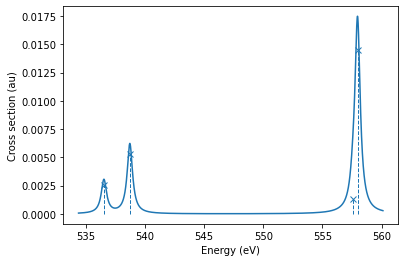

In [48]:
plt.figure(); adcres.plot_spectrum(); plt.show()

### TDDFT: eigenstates and CPP

SIE discussion below

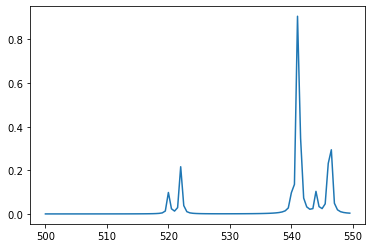

In [49]:
scf_settings    = {'conv_thresh': 1.0e-8}
method_settings = {'xcfun': 'b3lyp', 'grid_level': 4}
scf_drv = vlx.ScfRestrictedDriver(comm,silent_ostream)
scf_drv.update_settings(scf_settings, method_settings)
scf_drv.compute(molecule, basis)
from veloxchem.rsplinabscross import LinearAbsorptionCrossSection
freqs = np.arange(500.0,550.0,0.5)/27.2114
freqs_str = [str(x) for x in freqs]
cpp_prop = LinearAbsorptionCrossSection({'frequencies': ','.join(freqs_str), 'damping': 0.2/27.2114},method_settings)
cpp_prop.init_driver(comm, silent_ostream)
cpp_prop.compute(molecule, basis, scf_drv.scf_tensors)
sigma,sX,sY,sZ = [],[],[],[]
for w in freqs:
    axx = -cpp_prop.rsp_property['response_functions'][('x', 'x', w)].imag
    ayy = -cpp_prop.rsp_property['response_functions'][('y', 'y', w)].imag
    azz = -cpp_prop.rsp_property['response_functions'][('z', 'z', w)].imag
    alpha_bar = (axx + ayy + azz) / 3.0
    sigma.append(4.0 * np.pi * w * alpha_bar / 137.035999)
    sX.append(4.0 * np.pi * w * axx / (137.035999 * 3))
    sY.append(4.0 * np.pi * w * ayy / (137.035999 * 3))
    sZ.append(4.0 * np.pi * w * azz / (137.035999 * 3))
plt.figure(); plt.plot(au2ev*freqs,sigma); plt.show()

### Analysis

Vinylfluoride. CVS-ADC and CPP-DFT.

1. Chemical shifts

2. Atom assignment - illustrate

3. Polarization

4. Visualization and descriptors - illustrate/tabulate

### Uracil in solution

CVS-ADC and CPP-DFT

1. Tailored CVS spaces

2. Gas phase

3. Polarizable embedding

### Maybe: massive system with DFT

X-ray emission spectroscopy
--------------------------------------------

- maybe illustration: Augen/fluorescent yield

### Decay from core-hole reference

Water (vs expt)

1. ADC(2)

2. TDDFT

### Overlap model

Water (vs expt)

1. DFT

### Maybe: uracil in solution

1. Gas phase

2. Environment with PE

### Maybe valence-to-core XES

Suitable TM-complex with minimal static correlation

1. TDDFT

2. Overlap

### Maybe: massive system with DFT

Resonant inelastic X-ray scattering
--------------------------------------------------

Water.

1. 2-step model

2. DKH

XAS and XES coupled to MD
-----------------------------------------

Some system...

1. Dynamics + XAS

2. Dynamics + XES

3. Inclusion of environment?

4. Core-hole dynamics with some model?

Self-interaction error in DFT
----------------------------------------

For a single-electron systems the following equality should hold for the two-electron terms:

\begin{equation}
J[\rho] + E_{xc} [\rho] = 0.0
\end{equation}

This cancellation is achieved for, e.g. Hartree–Fock theory, but for any approximate functionals in DFT it will instead result in an erronous contribution to the energy. DFT-based methods generally suffer from self-interaction error (SIE), which corresponds to the sum of Coulomb and exchange self-interactions that remain because of the use of approximate exchange functionals. In more detail, the Coulomb self-repulsion of each electron included in the Coulomb operator is exactly canceled by the nonlocal exchange self-attraction in Hartree--Fock theory, but this is no longer the case when the exchange operator is replaced by an approximate exchange functional. The simplest correction to this error was proposed by Perdew and Zunger, by correcting the total exchange-correlation energy by a term, summed over all singly occupied orbitals

\begin{equation}
XE PZ = E DFT -
(J[\rho_i] + E_{xc}[\rho_i]).
\end{equation}

- Radial distribution or something for functionals? Calculate error?

Relativity
---------------

1. Water IP without relativity or with X2C

2. Total relativistic and correlation corrections as a function of Z

Relaxation
---------------

1. Radial distribution: Z, Z with hole, Z+1

2. Total density: formaldehyde

3. Maybe: visualization of effects for XAS and XES

<img src="../img/xray/relax_form.svg"  width="300px">

Basis set
---------------

IP with $\Delta$SCF and $\Delta$SCF.

1. 6-31+ versus u6-31G

2. cc-pVTZ versus cc-pCVTZ

3. cc-pCVnT

4. Maybe: cc-pVTZ + (Z+1)

Exercises
--------------

### XPS

### XAS

1. Compute the C K-edge X-ray absorption spectra of the ethylene molecule using CVS-ADC(0), CVS-ADC(1), and CVS-ADC(2) in combination with the def2-SVP basis set. Choose an appropriate core space. What are the differences between the spectra computed at the different CVS-ADC levels? Are the differences between levels of theory larger in the case of core excitations or valence excitations? 

2. Assignment

3. Compute also the C K-edge XAS spectra of difluoroethylene, and trifluoroethylene at the CVS-ADC(2) level of theory. Compare the spectra of ethylene, vinylfluoride, difluoroethylene, and trifluoroethylene to each other. What are the effects of fluorine substitution on the C K-edge spectrum? How large are the chemical shifts?

4. Basis set. Compare to above results for XPS - differences, similarities...

### XES

1. ADC(n)

2. Assignment

3. Basis set. Compare to above results for XPS - differences, similarities...

### SIE

1. XAS and XES error as a function of %HF-exchange
